In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from autoviz.AutoViz_Class import AutoViz_Class
import math
%matplotlib inline
from sklearn.linear_model import LinearRegression as lr
from sklearn.preprocessing import OrdinalEncoder as oe
from sklearn.preprocessing import StandardScaler
#　カラーパレット設定
color = [ "#68BBE3","#0E86D4", "#003060", "#055C9D", "#D9D9D9", "#FFFFFF", "#5A48AD"]
sns.set_palette(color, 10)
##  データ読み込み
client = pd.read_csv('./client.csv')
record = pd.read_csv('./record.csv')
record['Customer_ID'] = client['Customer_ID'].astype(int)
df = client.merge(record, how='outer', on='Customer_ID')
df.set_index('Customer_ID', inplace=True)
## ラベルエンコーディング
# for column in df.columns[df.dtypes=="object"]:
# 	df[column] = oe().fit_transform(df[column].values.reshape(-1, 1))
# 	df[column] = pd.Series(df[column], dtype=pd.Int64Dtype())
## データ通話はあまり関係なさそうなので削除
df = df[df.columns[~df.columns.str.contains("_dat_")]]
df.drop(columns="ccrndmou_Mean", inplace=True)


In [63]:
## EDA
my_report = sv.compare([df[df["churn"]==1].astype(float), "Churn"], [df[df["churn"]==0].astype(float), "Continue"], feat_cfg = sv.FeatureConfig(skip="refurb_new"))
my_report.show_html("sv_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report sv_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
av = AutoViz_Class()
autoviz = av.AutoViz(filename="", depVar='churn', dfte=df.astype(float), chart_format='server')

In [ ]:
plt.pie(df["churn"].value_counts().values, labels=["解約", "継続"], autopct='%1.1f%%',  shadow=True, explode=[0.1, 0], startangle=90)
plt.title("解約する割合")
plt.show()

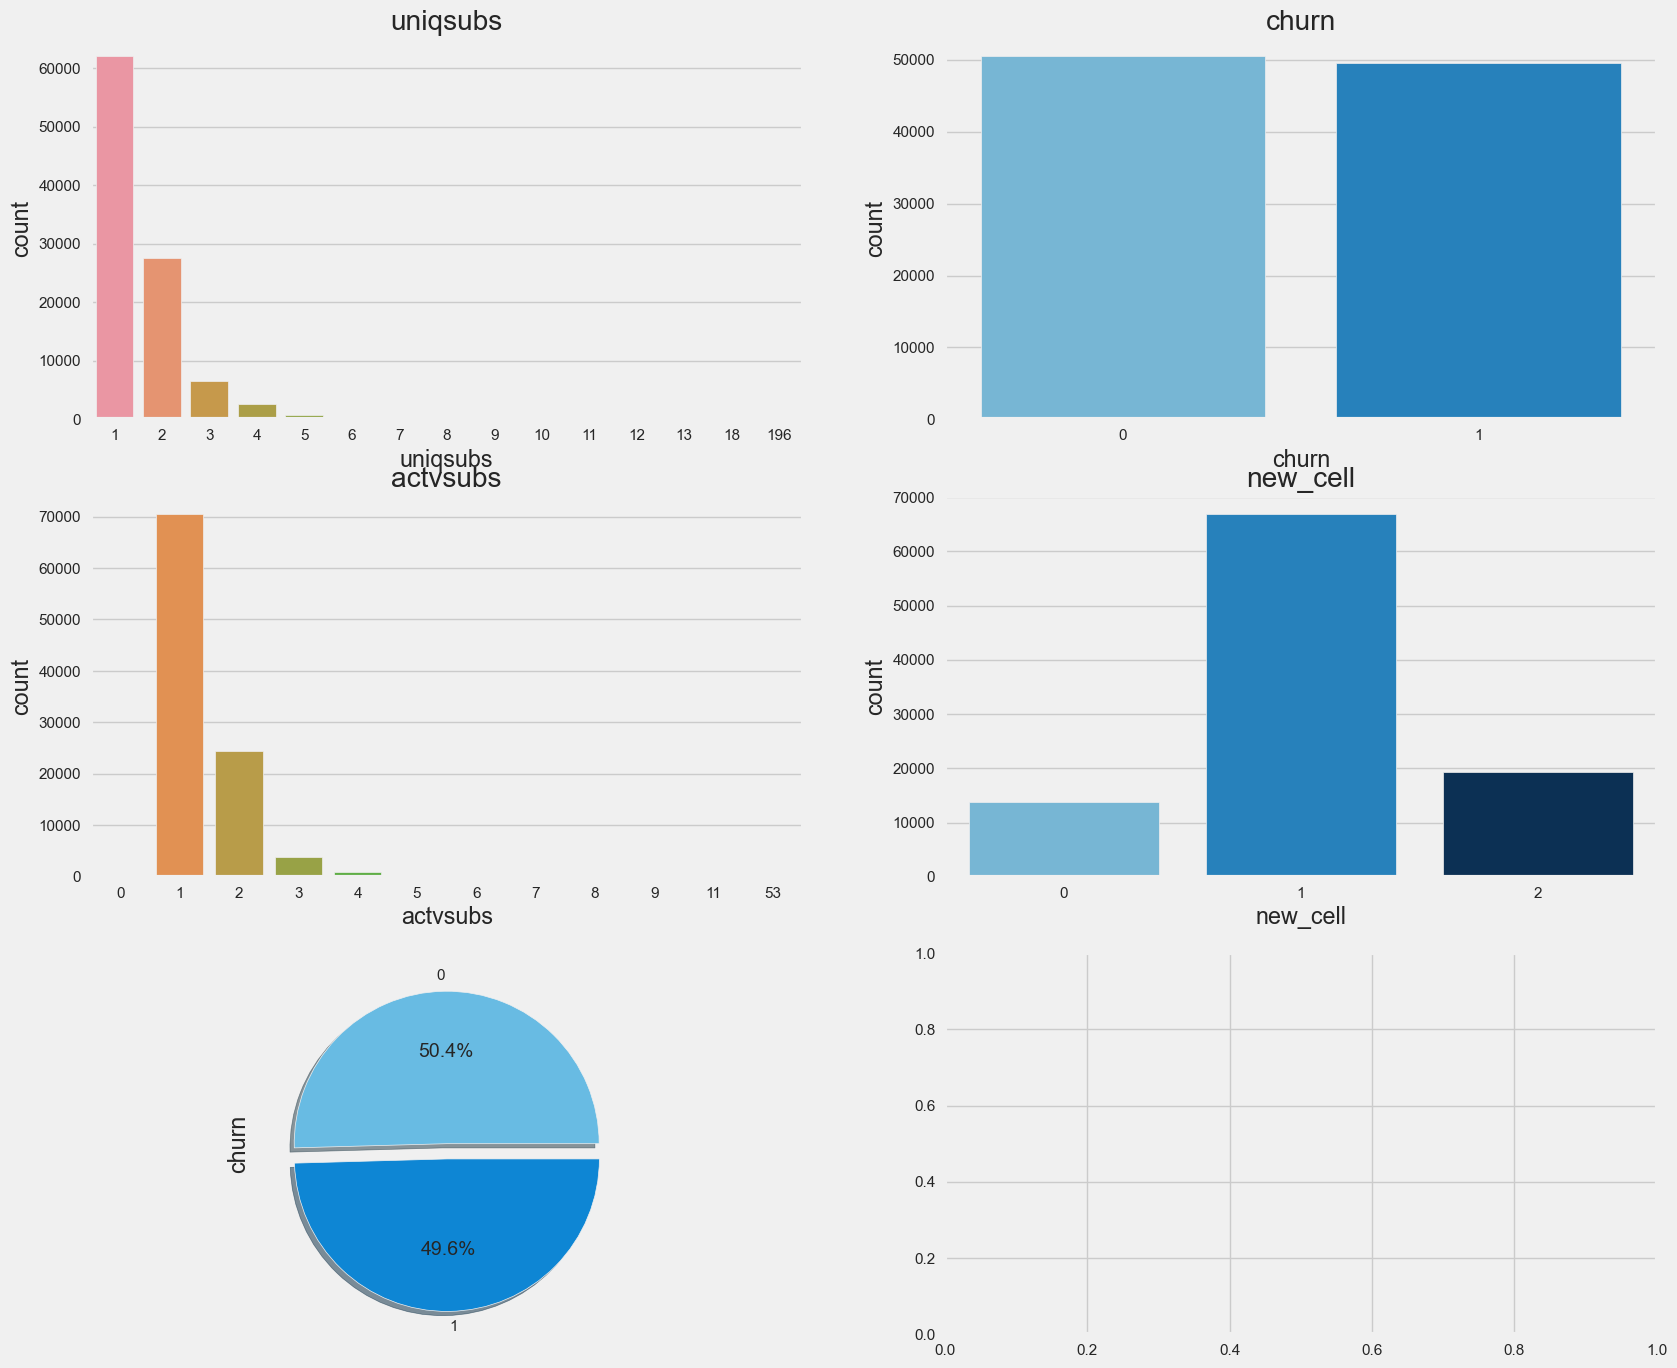

In [4]:
df['actvsubs'].describe()
f,ax=plt.subplots(3,2,figsize=(18,16))
df['churn'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[2,0],shadow=True)
ax[0,0].set_title('uniqsubs')
ax[0,0].set_ylabel('')
sns.countplot(x=df['uniqsubs'], ax=ax[0,0])
sns.countplot(x=df['actvsubs'], ax=ax[1,0])
sns.countplot(x=df['churn'], ax=ax[0,1])
sns.countplot(x=df['new_cell'], ax=ax[1,1])
ax[1,0].set_title('actvsubs')
ax[0,1].set_title('churn')
ax[1,1].set_title('new_cell')
plt.show()

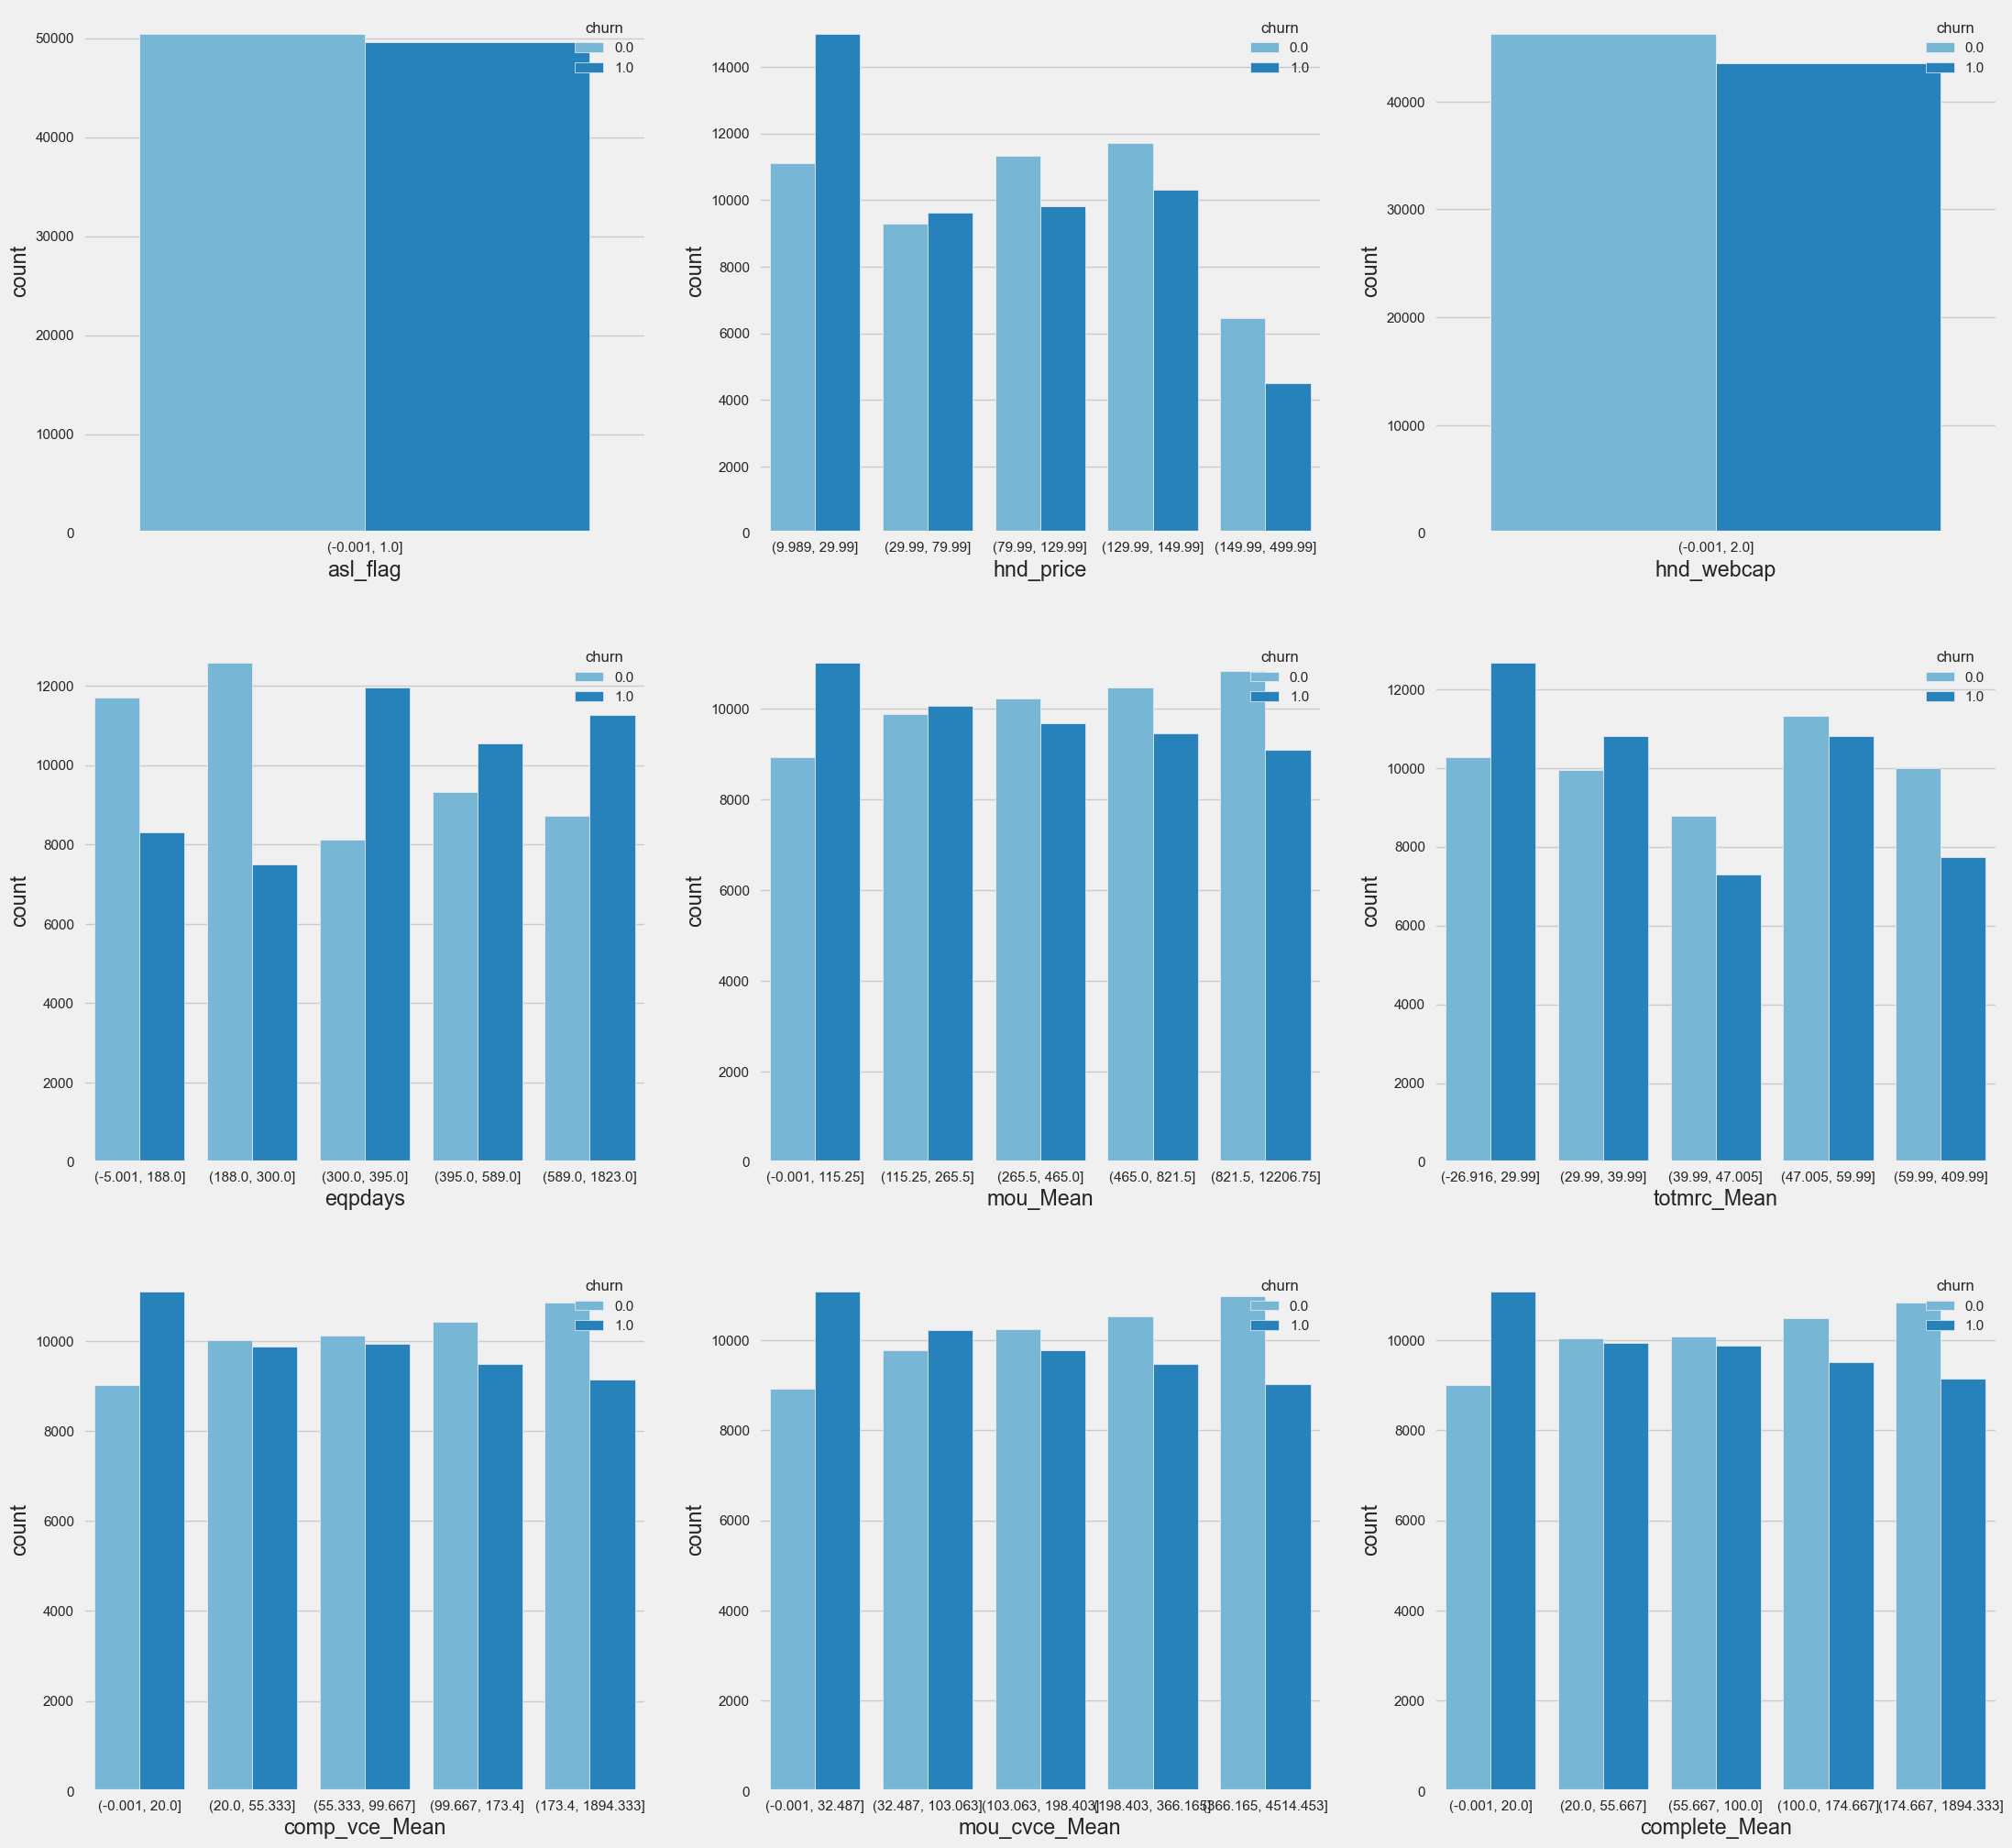

In [24]:
corr = df.corr()
list = corr.loc[abs(corr["churn"])>0.05,"churn"].drop("churn").index.tolist()
df_bin = df[list].astype(float)
for column in df_bin.columns[df_bin.dtypes=="float64"]:
	df_bin[column] = pd.qcut(df_bin[column], 5, duplicates='drop')
length = len(list)
f,axes=plt.subplots(round(length/3),3,figsize=(24,round(length/3)*8))
axes = axes.ravel()
df_bin["churn"] = df["churn"]
for column, ax in zip(list, axes):
	sns.countplot(x=column, hue="churn", data=df_bin, ax=ax)
plt.show()

In [7]:
## 欠損値の穴埋め
for column in df.drop(columns=["adults", "lor", "dwllsize", "hnd_price"]).isnull().any().index.tolist():
	if df[column].dtype == "float64":
		df[column].fillna(df[column].mean(), inplace=True)
	elif df[column].dtype == "Int64":
		df[column].fillna(round(df[column].mean()), inplace=True)
	else :
		df[column].fillna(df[column].mode(), inplace=True)
## 相関関係がある変数で予測
df_pred = df.drop(columns=["churn", "adults", "lor", "dwllsize", "hnd_price"])
pred_list = ["adults", "lor", "dwllsize", "hnd_price"]
for col in pred_list:
	df_pred[col] = df[col].copy()
	feature_num = len(df_pred.columns.tolist()) - 1
	X = df_pred.dropna(how='any',subset=[col]).drop(columns=col).values.reshape(-1, feature_num)
	y = df_pred.dropna(how='any',subset=[col])[col].values
	lr_fit = lr().fit(X, y)
	df[col] = df_pred.apply(lambda x: round(lr_fit.predict(np.nan_to_num(x[x.index!=col]).reshape(-1, feature_num))[0]) if  pd.isna(x[col]) or np.isnan(x[col]) else x[col], axis=1).copy()
	df_pred[col] = df[col].copy()
	

In [10]:
##  特徴量エンジニアリング
df["rev_3_Mean"] = df["rev_Mean"]/(df["change_rev"] + 1)
df["mou_3_Mean"] = df["mou_Mean"]/(df["change_mou"] + 1)
df["rev_rate"] = df["avgrev"] / df["income"]
df["kid"] = df["kid0_2"] + df["kid3_5"] + df["kid6_10"]
df["child"] = df["kid11_15"] + df["kid16_17"]
df["avgcm"] = df["avgqty"] / df["avgmou"]
df["call_Mean"] = df["drop_blk_Mean"]  + df["attempt_Mean"] + df["complete_Mean"] + df["callfwdv_Mean"] + df["callwait_Mean"]
df["drop_blk_rate_Mean"] = df["drop_blk_Mean"] / df["call_Mean"]
df["avgpre2rev"] = df["avg3rev"] - df["avgrev"]
df["avgpre2mou"] = df["avg3mou"] - df["avgmou"]
df["avgpre2qty"] = df["avg3qty"] - df["avgqty"]
df["avgpre3rev"] = df["avg6rev"] - df["avg3rev"]
df["avgpre3mou"] = df["avg6mou"] - df["avg3mou"]
df["avgpre3qty"] = df["avg6qty"] - df["avg3qty"]
df["change3_rev"] = (df["avgrev"] - df["avgpre3rev"])/df["avgpre3rev"]
df["change3_mou"] = (df["avgmou"] - df["avgpre3mou"])/df["avgpre3mou"]
df["change3_qty"] = (df["avgqty"] - df["avgpre3qty"])/df["avgpre3qty"]
df["prev4_rev"] = df["rev_3_Mean"] * 3 - df["avgpre2rev"] * 2
df["prev4_mou"] = df["mou_3_Mean"] * 3 - df["avgpre2mou"] * 2
df.drop(columns=["kid0_2", "kid3_5", "kid6_10", "kid11_15", "kid16_17", "avgrev", "avgmou", "avgqty"], inplace=True)
df.replace([np.inf, -np.inf, pd.NA],np.nan,inplace=True)
df.fillna(0, inplace=True)

In [11]:
## 標準化
ms = StandardScaler()
df_std = pd.DataFrame(ms.fit_transform(df[df.columns[df.dtypes=="float64"]]), columns=df.columns[df.dtypes=="float64"], index=df.index)
X_std = df[df.columns[df.dtypes!="float64"]].join(df_std)
y_std = df["churn"]

In [ ]:
import optuna.integration.lightgbm as lgb

from lightgbm import early_stopping
from lightgbm import log_evaluation
import sklearn.datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


if __name__ == "__main__":
    data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dval = lgb.Dataset(val_x, label=val_y)

    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        callbacks=[early_stopping(100), log_evaluation(100)],
    )

    prediction = np.rint(model.predict(val_x, num_iteration=model.best_iteration))
    accuracy = accuracy_score(val_y, prediction)

    best_params = model.params
    print("Best params:", best_params)
    print("  Accuracy = {}".format(accuracy))
    print("  Params: ")
    for key, value in best_params.items():
        print("    {}: {}".format(key, value))

In [15]:
from pycaret.classification import setup, compare_models
exp = setup(data = df_std, target = 'churn', session_id=123, fold_shuffle=True)
compare_models()

,Description,Value
0,session_id,123
1,Target,churn
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(100000, 102)"
5,Missing Values,False
6,Numeric Features,83
7,Categorical Features,18
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['TARGET'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('TARGET')
ax[0].set_ylabel('')
sns.countplot('TARGET',data=df,ax=ax[1])
ax[1].set_title('TARGET')
plt.show()

In [ ]:
categ_nominal = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE']

In [ ]:
for i in categ_nominal:
    df = pd.concat([df, pd.get_dummies(df[i], prefix=i, dummy_na=True)], sort=False, axis=1)
df = df.drop(categ_nominal, axis=1)
df.info()

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [ ]:
X = df.drop('TARGET',axis=1) 
y = df['TARGET'] # 目的変数
# トレーニングデータ,テストデータの分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.2, random_state=0)

今回は不均衡データであることから、評価指標にはAUCを用いることにします。適切な評価指標を選ぶことは最終課題でも重要です。

In [ ]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train) 

# パラメータ
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # 目的 : 分類
        'metric': {'auc'},
         'num_leaves': 20,             
        'max_depth':5,
        'min_data_in_leaf': 3,        
        'num_iteration': 100,            
        'learning_rate':0.03,
        'num_boost_round':100,
         'early_stopping_rounds':20, 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# テストデータの予測
y_pred = model.predict(X_valid)

モデルの学習が終わりました。決定木ベースのアンサンブル分析器では特徴量の重要度を算出することができるため、可視化してみます。

In [ ]:
lgb.plot_importance(model, height=0.5, figsize=(30,40))

モデルの学習に当たって重要と判断された特徴量について可視化することができました。重要と判断された特徴量に関していくつか検討してみることにします。それぞれの特徴量に関して、平均値や中央値、データの分布を確認し、債務不履行の有無でウィルコクソンの順位和検定を有意水準を5%として検定し、2群の中央値に有意差があるか検討してみます。

まずはEXT_SOURCE_1に関して検討します。

In [ ]:
df.groupby(["TARGET"])["EXT_SOURCE_1"].mean()

In [ ]:
df.groupby(["TARGET"])["EXT_SOURCE_1"].median()

実際に債務不履行の有無によるEXT_SOURCE_1の中央値やヒストグラムを可視化してみましょう。

In [ ]:
sns.barplot(x='TARGET', y='EXT_SOURCE_1', data=df, estimator=np.median)

In [ ]:
df.groupby('TARGET')['EXT_SOURCE_1'].plot.hist(bins=20, alpha=0.5, legend=True)

ウィルコクソンの順位和検定を有意水準を5%として検定し、2群の中央値に有意差があるか検討してみます。

In [ ]:
from scipy import stats
s, pvalue = stats.mannwhitneyu(df[df["TARGET"]==1]["EXT_SOURCE_1"]
                , df[df["TARGET"]==0]["EXT_SOURCE_1"]
                ,alternative='two-sided')
pvalue < 0.05

この検定より、債務不履行の有無に関してEXT_SOURCE_1には有意差があり、カラム名から察するに外部からの、この信用スコアのようなものが高いと債務不履行になりにくいことが分かりました。反対に、顧客データから顧客の信用スコアを求めることで他社に有益な情報を供与できるかもしれません。信用スコアを他社に提供する分、顧客に還元するアイデアなども考えられます。


次に、DAYS_BIRTHについて検討します。

In [ ]:
df.groupby(["TARGET"])["DAYS_BIRTH"].mean()

In [ ]:
df.groupby(["TARGET"])["DAYS_BIRTH"].median()

In [ ]:
sns.barplot(x='TARGET', y='DAYS_BIRTH', data=df, estimator=np.median)

In [ ]:
df.groupby(["TARGET"])["DAYS_BIRTH"].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
s, pvalue = stats.mannwhitneyu(df[df["TARGET"]==1]["DAYS_BIRTH"]
                , df[df["TARGET"]==0]["DAYS_BIRTH"]
                ,alternative='two-sided')
pvalue < 0.05

この検定より、債務不履行の有無に関してDAYS_BIRTHには有意差があることが分かりました。値を鑑みるに、年齢は数字の絶対値が小さい方が若いと考えられるので、若い人の方が債務不履行になりやすいと言え、若年層が返済しやすい融資プランの需要があることが予想できます。

次に、AMT_CREDIT(融資額)について検討します。

In [ ]:
df.groupby(["TARGET"])["AMT_CREDIT"].mean()

In [ ]:
df.groupby(["TARGET"])["AMT_CREDIT"].median()

In [ ]:
sns.barplot(x='TARGET', y='AMT_CREDIT', data=df, estimator=np.median)

In [ ]:
df.groupby(["TARGET"])["AMT_CREDIT"].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
s, pvalue = stats.mannwhitneyu(df[df["TARGET"]==1]["AMT_CREDIT"]
                , df[df["TARGET"]==0]["AMT_CREDIT"]
                ,alternative='two-sided')
pvalue < 0.05

この検定より、債務不履行の有無に関してAMT_CREDITには有意差があることが分かりました。値が小さい方が債務不履行になりやすいという結果なので、問題は借入金の総額ではなく、収入との問題があるのかもしれません。収入AMT_INCOME_TOTALに関して検討してみます。

In [ ]:
df.groupby(["TARGET"])["AMT_INCOME_TOTAL"].mean()

In [ ]:
df.groupby(["TARGET"])["AMT_INCOME_TOTAL"].median()

In [ ]:
sns.barplot(x='TARGET', y='AMT_INCOME_TOTAL', data=df, estimator=np.median)

In [ ]:
df.groupby(["TARGET"])["AMT_INCOME_TOTAL"].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
df.groupby(["TARGET"])["AMT_INCOME_TOTAL"].plot.hist(bins=20, alpha=0.5,log=True, legend=True)
#スケールが見にくいので対数変換

In [ ]:
s, pvalue = stats.mannwhitneyu(df[df["TARGET"]==1]["AMT_INCOME_TOTAL"]
                , df[df["TARGET"]==0]["AMT_INCOME_TOTAL"]
                ,alternative='two-sided')
pvalue < 0.05

この検定より、債務不履行の有無に関してAMT_INCOME_TOTALには有意差があることが分かりました。値が小さい方が債務不履行になりやすいという結果なので、収入が少ない人の方が債務不履行になりやすいということが分かりました。ここから、収入が少ない人への適切な融資プランの需要が考えられます。

先ほど予想したように、借入金が多ければ債務不履行になりやすいという訳ではないようなので、収入と借入金の割合について考えてみたいと思います。

In [ ]:
df['Ratio_of_income_to_debt']=df['AMT_CREDIT']/df['AMT_INCOME_TOTAL']
df.groupby(["TARGET"])["Ratio_of_income_to_debt"].mean()

In [ ]:
df.groupby(["TARGET"])["Ratio_of_income_to_debt"].median()

In [ ]:
sns.barplot(x='TARGET', y='Ratio_of_income_to_debt', data=df, estimator=np.median)

In [ ]:
df.groupby('TARGET')['Ratio_of_income_to_debt'].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
s, pvalue = stats.mannwhitneyu(df[df["TARGET"]==1]["Ratio_of_income_to_debt"]
                , df[df["TARGET"]==0]["Ratio_of_income_to_debt"]
                ,alternative='two-sided')
pvalue < 0.05

どうやら、債務不履行かどうかは年収と借入金の比では決定しないようです。収入が少ない人の場合、借入金の割合や額が少なくても債務不履行になるケースが多いのかもしれません。

今回は上手くいきませんでしたが、仮説を立ててデータを色々な角度から分析するのは企業の課題を見つけるのに有効な手段の一つです。

ここまでのデータ分析から、**外部の信用スコアが重要であることや、若者や収入の少ない人は債務不履行者になりやすい課題**が見えてきました。
今回は簡便な方法でEDAを行いましたが、更に深く探索を行うことや、全く別の観点からEDAを行うことは評価に繋がります。

今回はEDAの手段としてLightGBMを用いましたが、この学習結果をモデル構築の一部とすることも可能です。**最終課題では、データ分析結果を可視化して提示し、どのようなことが明らかになったのか示すとともに、機械学習によるモデル構築を行いましょう。この流れに沿って行けば、どのような事業提案を行ったらよいかが見えてくると思います。**

tips:可視化を行う際に、日本語を軸の名前などに記述したい時にはjapanize_matplotlibを用いると便利です。調べてみてください。

最終課題の説得力を上げる一つの方法としては、事業に定量性を持たせることです。機械学習モデルを用いて、例えば今回のケースなら債務不履行者による損失がどれだけ減らせるか示すことができれば、定量性が上がり説得力が増します。


まず、機械学習する前のHome Credit社の損失合計を求めてみます。債務不履行者の合計金額を求めればいいですから、

In [ ]:
loss_sum=df[df["TARGET"]==1]
loss_sum['AMT_CREDIT'].sum()

これより、通貨単位をドルとして、7665723153ドルの損失があることが分かりました。ここで、今回機械学習で債務不履行者と予測した融資金額の合計を算出します。なお、債務不履行者かどうかは、実際の債務不履行者の割合が8%程度であることを考え、今回は大雑把ですが予測確率が上位の5%より小さいかどうかで判定してみます。

In [ ]:
X_valid['pred']=y_pred
X_valid['pred'].hist()

In [ ]:
threshold=X_valid['pred'].quantile(0.95)
print(threshold)
X_valid.loc[X_valid['pred'] < threshold, 'pred'] = 0
X_valid.loc[X_valid['pred'] >= threshold, 'pred'] = 1

In [ ]:
loss_pred=X_valid[X_valid["pred"]==1]
loss_pred['AMT_CREDIT'].sum()

In [ ]:
787740439.5/0.8

債務不履行者と予測した人への融資金額は787740439.5ドルでした。訓練データ・テストデータの分割(8割と2割)を考慮すると、これらがほぼランダムに分割できているのであれば984675549.375ドルの損失があると言えます。機械学習を用いて債務不履行者と判定した人に融資を行わなければ、これだけの損失を回避することができます。ただし、この計算ではモデルの性能等を全く考慮していないので、やや乱暴な理論と言えます。しかし、ただ機械学習をして債務不履行者を予測します、と事業提案されるよりは具体的で分かりやすい説明になると言えます。

本サンプルでは行っておりませんが、**市場調査を行うことも説得力の観点で大事**です。例えば同業他社ではどのような問題を抱えており、その課題をいかにデータで解決できるか示すことができれば説得力を増すことができます。

以上で最終課題のサンプルとします。

最終課題の評価を上げるには、データ分析を綿密に行うこと、モデルの性能を高めること、斬新な事業を提案すること、隙のない議論に基づいた定量性のある事業を提案することなどが考えられます。また、事業提案ですので、ビジネスモデルキャンバスやリーンキャンバスを用いることも有効だと考えられます。ぜひ調べてみてください。非常にチャレンジングな課題ですが、今まで学んだことを活かしてデータ分析や機械学習を用いた事業を提案して下さい。皆さんの力作をお待ちしております。